# UKCP18 Days TAS Above Indicator example via Hazard

This notebook should be able to run independantly as long as you've installed the repositories requirements.

For example, I used the `pdm` approach:

```
pip install pdm
pdm config venv.with_pip True
pdm install
```

You will also need `CEDA` FTP credentials. This notebook expects the following environment variables:

```
CEDA_FTP_URL="ftp.ceda.ac.uk"
CEDA_USERNAME=<your-general-ceda-username>
CEDA_FTP_PASSWORD=<your-ceda-ftp-password> # This is separate to your normal CEDA login password - See: https://help.ceda.ac.uk/article/280-ftp
```

## Setup imports

In [1]:
import logging
import os
import sys

from dask.distributed import Client, LocalCluster
import zarr

from hazard.docs_store import DocStore
from hazard.models.days_tas_above import DaysTasAboveIndicator
from hazard.sources.ukcp18 import Ukcp18
from hazard.sources.osc_zarr import OscZarr

/Users/ciaran/dev/os-climate-hazard/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Setup Hazard

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] {%(filename)s:%(lineno)d} %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(filename="batch.log"),
        logging.StreamHandler(sys.stdout),
    ],
)

cluster = LocalCluster(processes=False)
client = Client(cluster)

gcm = "ukcp18"
scenario = "rcp85"
year = 2030
source = Ukcp18(os.environ["CEDA_FTP_URL"], os.environ["CEDA_USERNAME"], os.environ["CEDA_FTP_PASSWORD"])

# Just store stuff locally as it's easier
test_output_dir = os.path.join(os.getcwd(), "src/test/test_output")
store = zarr.DirectoryStore(os.path.join(test_output_dir, "hazard", "hazard.zarr"))
target = OscZarr(store=store)

model = DaysTasAboveIndicator(
    threshold_temps_c=[15],
    window_years=1,
    gcms=[gcm],
    scenarios=[scenario],
    central_years=[year],
)

/Users/ciaran/dev/os-climate-hazard/.venv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62255 instead
  warnings.warn(


[2024-07-18 12:23:56,782] {days_tas_above.py:56} INFO - Starting calculation for year 2030
[2024-07-18 12:24:04,757] {days_tas_above.py:60} INFO - Calculation complete for year 2030


## Run model

In [3]:
model.run_all(source, target, client=client)

[2024-07-18 12:23:53,355] {multi_year_average.py:112} INFO - Calculating average indicator for batch item gcm=ukcp18, scenario=rcp85, central_year=2030, years=[2030]
[2024-07-18 12:24:04,760] {multi_year_average.py:81} INFO - Writing array to chronic_heat/osc/v2/days_tas_above_15c_ukcp18_rcp85_2030
[2024-07-18 12:24:04,766] {map_utilities.py:46} INFO - Generating map projection for file chronic_heat/osc/v2/days_tas_above_15c_ukcp18_rcp85_2030; reading file
[2024-07-18 12:24:04,768] {map_utilities.py:48} INFO - Reprojecting to EPSG:3857
[2024-07-18 12:24:04,786] {map_utilities.py:54} INFO - Writing map file chronic_heat/osc/v2/days_tas_above_15c_ukcp18_rcp85_2030_map


## Visualise indicator

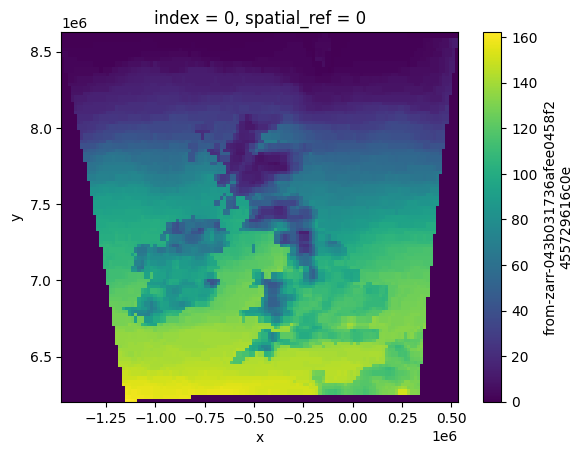

In [4]:
indicator = target.read("chronic_heat/osc/v2/days_tas_above_15c_ukcp18_rcp85_2030_map")
indicator.plot()